In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

from textblob import TextBlob
import spacy
import textstat

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hritikjhaveri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset
true_df = pd.read_csv("/Users/hritikjhaveri/Desktop/UChicago/Q3/Machine_Learning_II/Project/Data/True.csv")
fake_df = pd.read_csv("/Users/hritikjhaveri/Desktop/UChicago/Q3/Machine_Learning_II/Project/Data/Fake.csv")

# Add labels
true_df['label'] = 'True'
fake_df['label'] = 'Fake'

# Combine both datasets
df = pd.concat([true_df, fake_df], ignore_index=True)

In [4]:
print("Shape:", df.shape)
print("Columns:", df.columns)
print(df.info())
print(df.describe(include='all'))

Shape: (44898, 5)
Columns: Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB
None
                                                    title   text  \
count                                               44898  44898   
unique                                              38729  38646   
top     Factbox: Trump fills top jobs for his administ...          
freq                                                   14    627   

             subject                date  label  
count          44898               44898  44898  
unique             8                2397      2  
t

In [ ]:
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True


In [6]:
df['label'].value_counts(normalize=True)

label
Fake    0.522985
True    0.477015
Name: proportion, dtype: float64

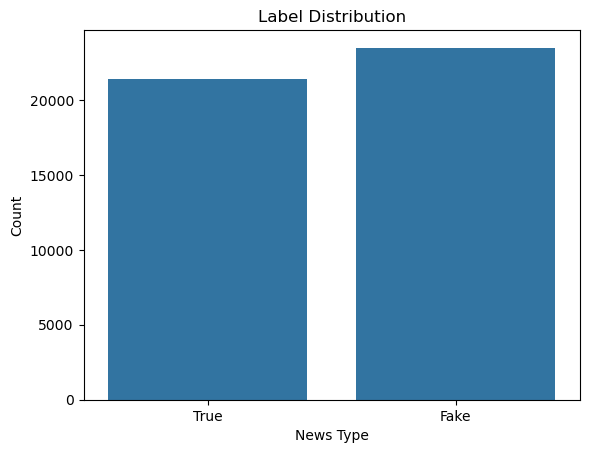

In [7]:
sns.countplot(x='label', data=df)
plt.title("Label Distribution")
plt.xlabel("News Type")
plt.ylabel("Count")
plt.show()

1. Label Distribution
Description: A bar chart showing the count of "Fake" and "True" news labels.

Interpretation:
The dataset is relatively balanced with a slightly higher number of fake news articles than true ones. This balance is beneficial for training classification models, reducing the need for heavy resampling.

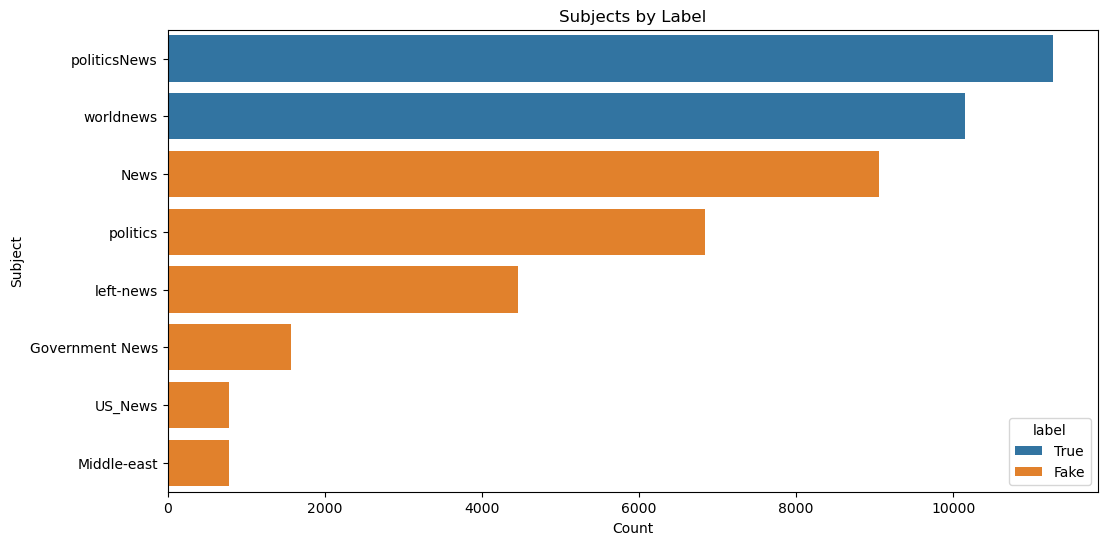

In [8]:
plt.figure(figsize=(12,6))
sns.countplot(y='subject', hue='label', data=df, order=df['subject'].value_counts().index)
plt.title("Subjects by Label")
plt.xlabel("Count")
plt.ylabel("Subject")
plt.show()

2. Subject Distribution by Label
Description: Horizontal bar chart showing the distribution of news subjects, split by label.

Interpretation:

The "politicsNews" subject dominates in the "True" label.

The "News" and "worldnews" subjects are more common in the "Fake" label.
This suggests that fake news is more broadly categorized and less specific, while true news focuses more narrowly on defined political topics.

/var/folders/dt/v3nm1w8n3h17hbjrmb81xy4r0000gn/T/ipykernel_74064/2706710443.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('date').resample('M').size().plot()


<Axes: xlabel='date'>

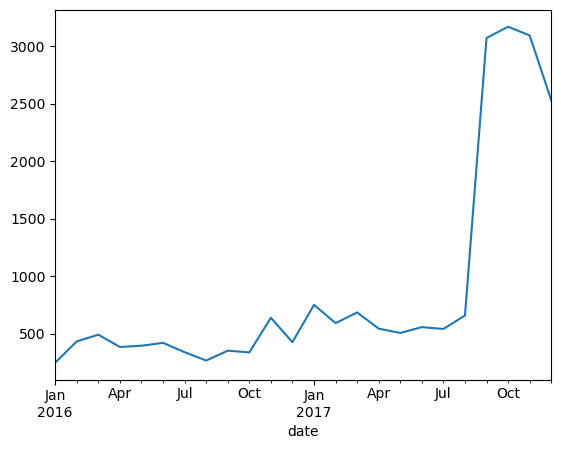

In [9]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.set_index('date').resample('M').size().plot()

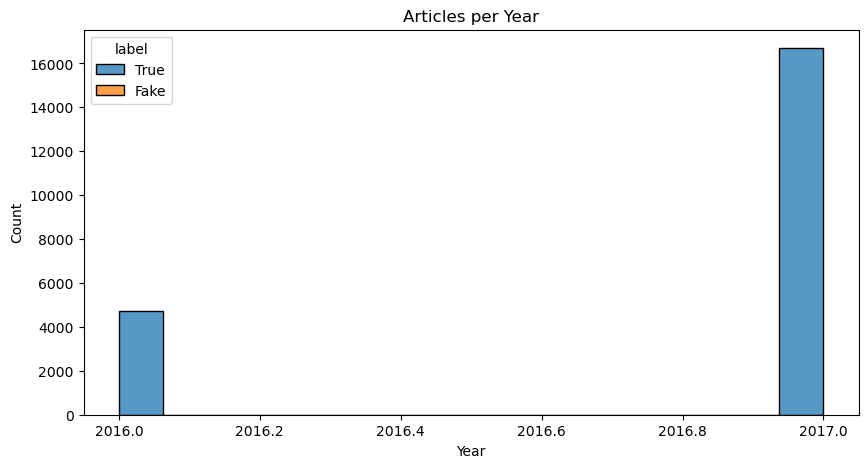

In [10]:
# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

# Plot article count per year
plt.figure(figsize=(10,5))
sns.histplot(df, x='year', hue='label', multiple='stack')
plt.title("Articles per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

3. Articles per Year
Description: Histogram showing the number of articles per year for both labels.

Interpretation:
There is a noticeable spike in article publication around 2016–2017, corresponding to politically significant periods (e.g., the U.S. election). Fake news articles appear slightly more distributed across years, while true news clusters more around key events.

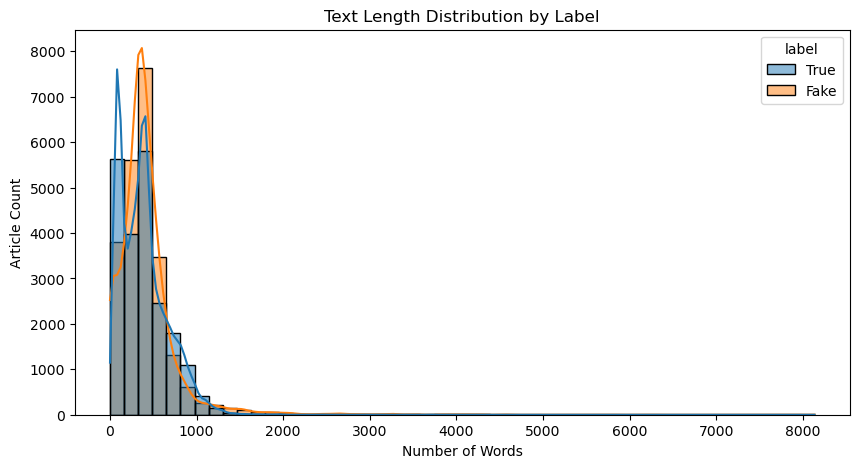

In [11]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,5))
sns.histplot(df, x='text_length', hue='label', bins=50, kde=True)
plt.title("Text Length Distribution by Label")
plt.xlabel("Number of Words")
plt.ylabel("Article Count")
plt.show()

4. Text Length Distribution by Label
Description: Histogram comparing word counts across articles, separated by label.

Interpretation:
True news articles generally contain more words, indicating deeper coverage or detailed reporting. Fake news articles tend to be shorter, which may reflect oversimplified or sensationalized content.

Missing values:
 title               0
text                0
subject             0
date            23481
label               0
year            23481
text_length         0
exclamations        0
caps_ratio          0
dtype: int64
Outliers in text length: 1678


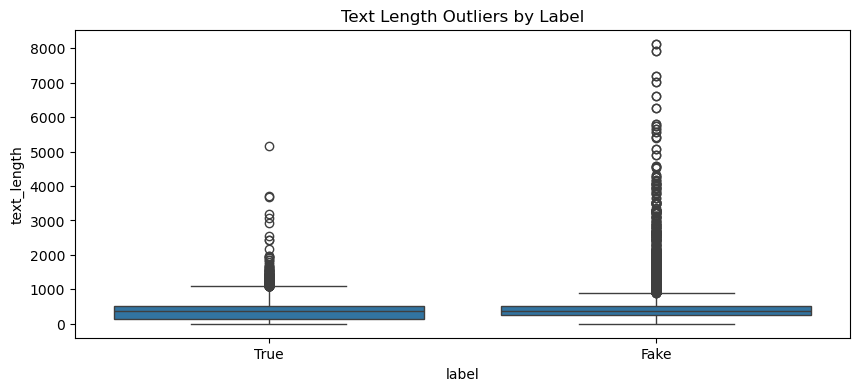

In [13]:
# Check missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

# Already added in previous step: df['text_length']
q1 = df['text_length'].quantile(0.25)
q3 = df['text_length'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]
print(f"Outliers in text length: {len(outliers)}")

# Optional: Visualize outliers
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='label', y='text_length')
plt.title("Text Length Outliers by Label")
plt.show()

5. Outlier Detection in Text Length
Description: Boxplot displaying article text lengths and identifying outliers.

Interpretation:
The fake news class shows a wider range of text lengths and more extreme outliers. These may include either unusually brief or excessively long articles, which could distort model performance and should be considered for cleaning or capping.


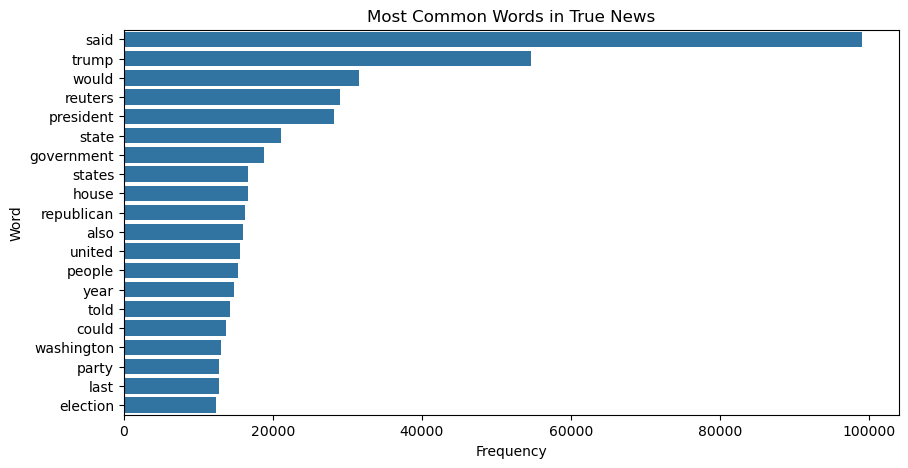

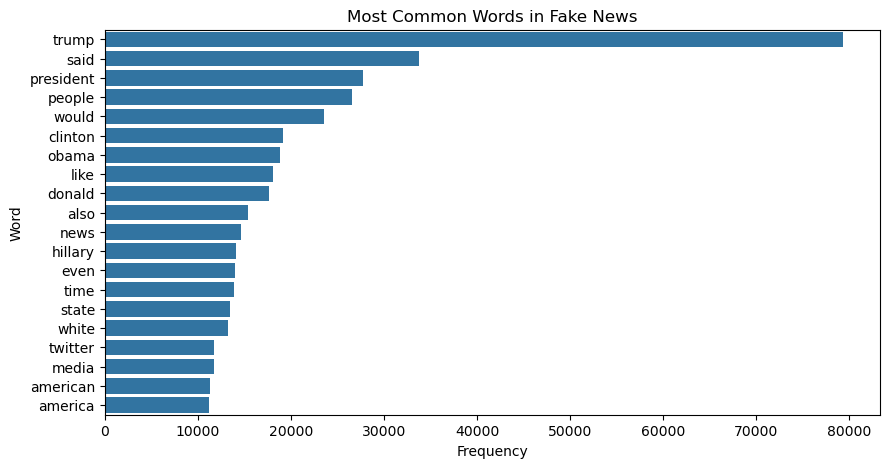

In [14]:
# Helper to clean and tokenize text
def clean_text(text):
    tokens = re.findall(r'\b[a-zA-Z]{4,}\b', str(text).lower())  # Remove short words and numbers
    return [word for word in tokens if word not in stopwords.words('english')]

# Combine all words for each label
true_words = df[df['label'] == 'True']['text'].apply(clean_text).explode()
fake_words = df[df['label'] == 'Fake']['text'].apply(clean_text).explode()

# Get most common words
true_counts = Counter(true_words).most_common(20)
fake_counts = Counter(fake_words).most_common(20)

# Plot
def plot_common_words(word_counts, label):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(10,5))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f"Most Common Words in {label} News")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.show()

plot_common_words(true_counts, "True")
plot_common_words(fake_counts, "Fake")

6. Missing Values
Description: Summary table showing missing data per column.

Interpretation:
The date and derived year columns have missing values exclusively in the "Fake" dataset. This limits the effectiveness of time-based analysis and should be handled explicitly (e.g., dropping, imputing, or treating as a categorical absence).

In [15]:
# Use small sample to avoid memory issues
sample_df = df.sample(1000, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(sample_df['text'])

# Cosine similarity matrix (optional preview)
similarity_matrix = cosine_similarity(X_tfidf[:5])

print("Sample cosine similarity (top 5 articles):\n", similarity_matrix)

Sample cosine similarity (top 5 articles):
 [[1.         0.06671836 0.03699918 0.05120727 0.00619354]
 [0.06671836 1.         0.03616592 0.0345407  0.02834924]
 [0.03699918 0.03616592 1.         0.04363453 0.01551795]
 [0.05120727 0.0345407  0.04363453 1.         0.01153947]
 [0.00619354 0.02834924 0.01551795 0.01153947 1.        ]]


11. Cosine Similarity of TF-IDF Vectors
Description: Cosine similarity matrix between a sample of TF-IDF-encoded articles.

Interpretation:
Low average similarity between articles suggests that the content is diverse, which is ideal for training robust models. However, high similarity within a label could point to repeated narratives or phrasing patterns worth investigating.

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Embedding shape: (500, 384)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


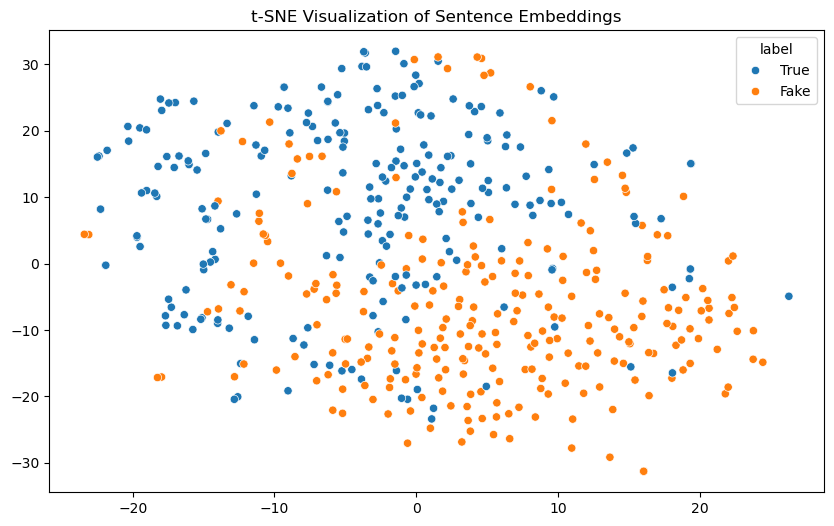

In [16]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Small & fast

# Limit to 500 articles for speed
embed_sample = df.sample(500, random_state=1)
embeddings = model.encode(embed_sample['text'].tolist(), show_progress_bar=True)

print("Embedding shape:", np.array(embeddings).shape)

# Optional: Dimensionality Reduction & Visualization
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=tsne_embeddings[:,0], y=tsne_embeddings[:,1], hue=embed_sample['label'])
plt.title("t-SNE Visualization of Sentence Embeddings")
plt.show()

12. Sentence Embedding Visualization (MiniLM + t-SNE)
Description: t-SNE plot showing the reduced 2D representation of sentence embeddings.

Interpretation:
The distribution of sentence embeddings shows some separation between fake and true news articles. This indicates that semantic content differs by label and that transformer-based embeddings capture meaningful distinctions that can be used in classification models.



In [17]:
df['exclamations'] = df['text'].str.count('!')
df['caps_ratio'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / max(len(str(x)),1))

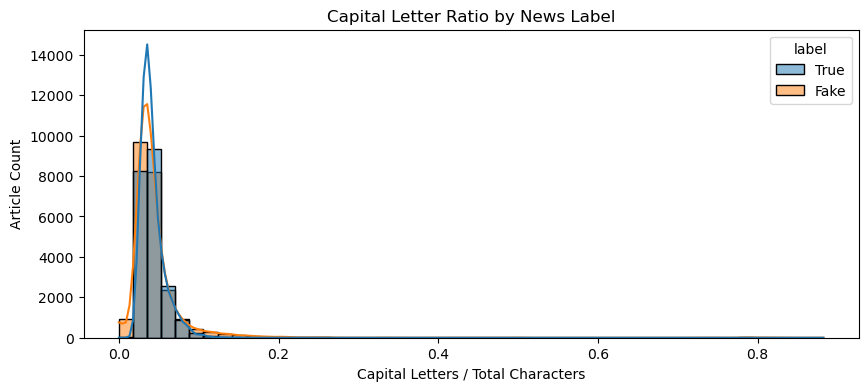

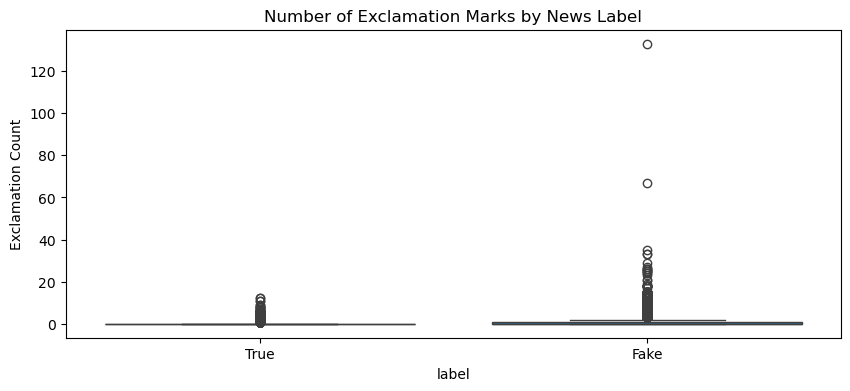

In [18]:
# Plot: Capital letter ratio
plt.figure(figsize=(10,4))
sns.histplot(data=df, x='caps_ratio', hue='label', bins=50, kde=True)
plt.title("Capital Letter Ratio by News Label")
plt.xlabel("Capital Letters / Total Characters")
plt.ylabel("Article Count")
plt.show()

# Plot: Exclamation usage
plt.figure(figsize=(10,4))
sns.boxplot(data=df, x='label', y='exclamations')
plt.title("Number of Exclamation Marks by News Label")
plt.ylabel("Exclamation Count")
plt.show()

7. Capitalization and Punctuation Analysis
Description:

Histogram of uppercase character ratios

Boxplot of exclamation mark counts by label

Interpretation:
Fake news contains a higher proportion of capital letters and uses exclamation marks more frequently, which may be linked to emotional appeal or aggressive writing styles often used to draw attention.

In [19]:
df['readability'] = df['text'].apply(textstat.flesch_reading_ease)

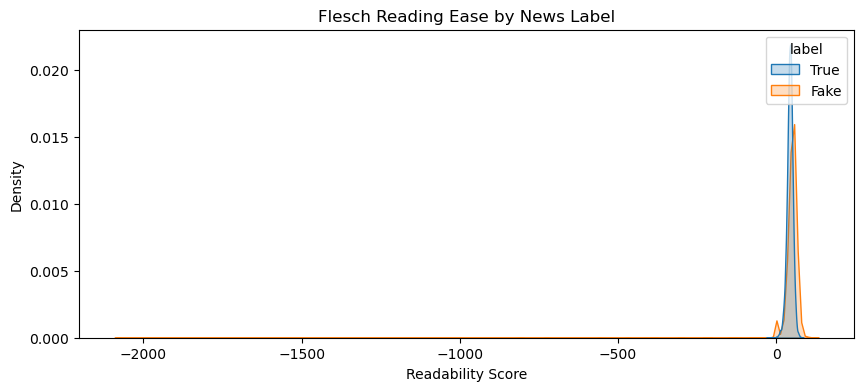

In [20]:
# Plot
plt.figure(figsize=(10,4))
sns.kdeplot(data=df, x='readability', hue='label', fill=True)
plt.title("Flesch Reading Ease by News Label")
plt.xlabel("Readability Score")
plt.ylabel("Density")
plt.show()

In [3]:
clickbait_words = ['shocking', 'you won\'t believe', 'what happened next', 'never expected']
df['clickbait'] = df['title'].apply(lambda x: any(word in x.lower() for word in clickbait_words))

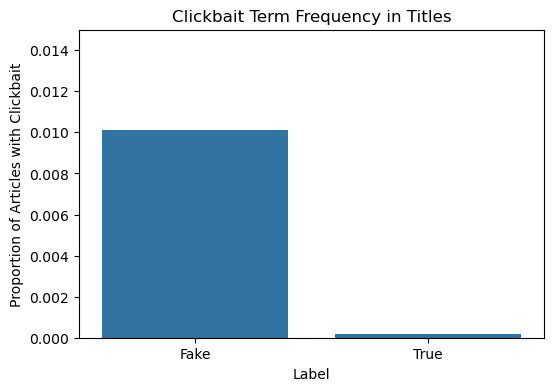

In [7]:
# Plot
clickbait_counts = df.groupby('label')['clickbait'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='label', y='clickbait', data=clickbait_counts)
plt.title("Clickbait Term Frequency in Titles")
plt.ylabel("Proportion of Articles with Clickbait")
plt.xlabel("Label")
plt.ylim(0, 0.015)
plt.show()

8. Clickbait Detection
Description: Bar chart of the proportion of titles containing clickbait phrases.

Interpretation:
Clickbait terms like "shocking", "you won't believe", and "what happened next" are more frequent in fake news titles. These serve as strong features for identifying potentially deceptive or attention-seeking articles.

In [23]:
df['sentiment'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

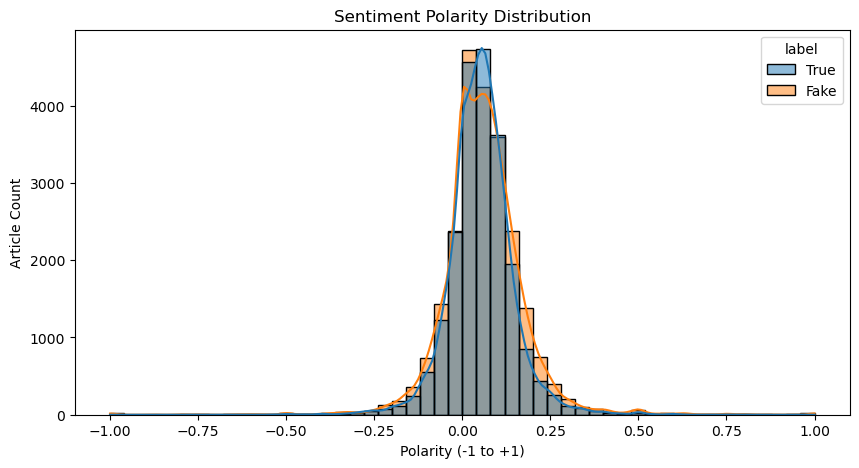

In [24]:
# Plot sentiment distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='sentiment', hue='label', bins=50, kde=True)
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Polarity (-1 to +1)")
plt.ylabel("Article Count")
plt.show()

9. Sentiment Polarity Analysis
Description: Histogram of sentiment polarity scores from TextBlob, with KDE curves for each label.

Interpretation:
True news tends to have neutral sentiment polarity (scores near 0), indicating objective reporting. Fake news spans a broader sentiment range, often leaning toward emotionally charged language, either very positive or very negative.

In [25]:
# Check duplicated title+text combinations
df['is_duplicate'] = df.duplicated(subset=['title', 'text'], keep=False)

# Count duplicates per label
duplicate_counts = df.groupby('label')['is_duplicate'].sum().reset_index()

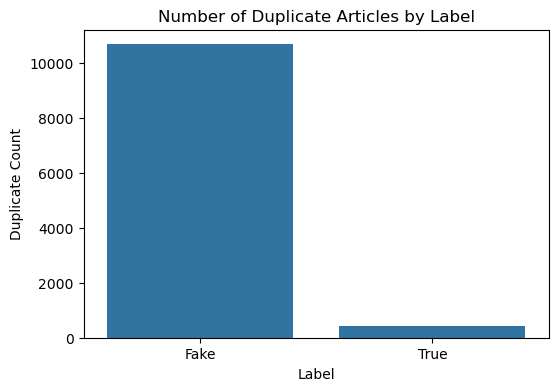

In [26]:
plt.figure(figsize=(6,4))
sns.barplot(data=duplicate_counts, x='label', y='is_duplicate')
plt.title("Number of Duplicate Articles by Label")
plt.ylabel("Duplicate Count")
plt.xlabel("Label")
plt.show()

10. Duplicate Article Detection
Description: Bar chart of article duplication counts by label.

Interpretation:
There are more duplicate entries in the fake news class. This could indicate automated content replication or coordinated misinformation campaigns. De-duplicating content may improve dataset quality and model generalization.

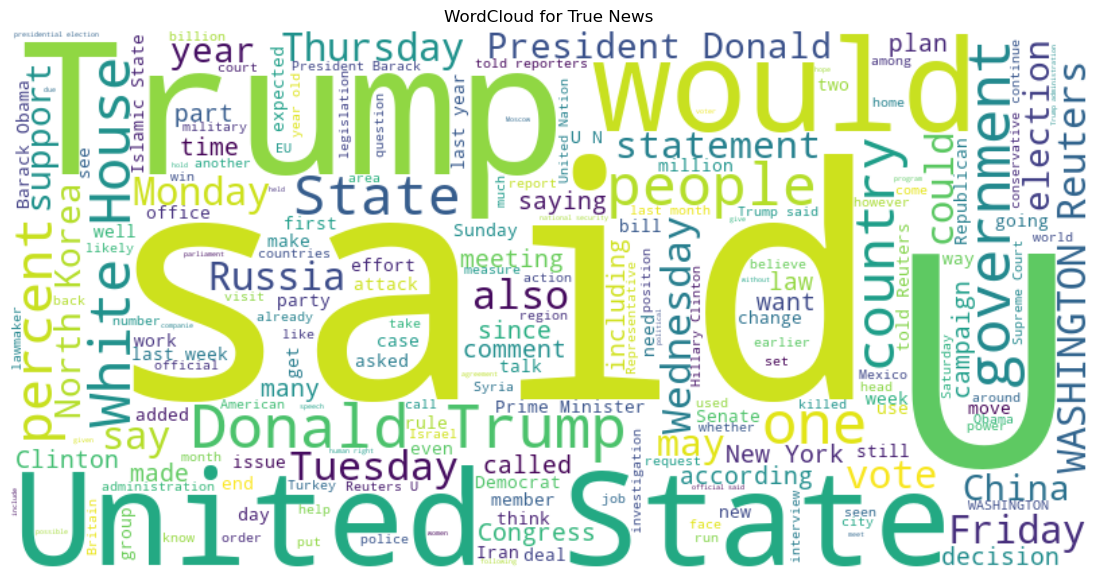

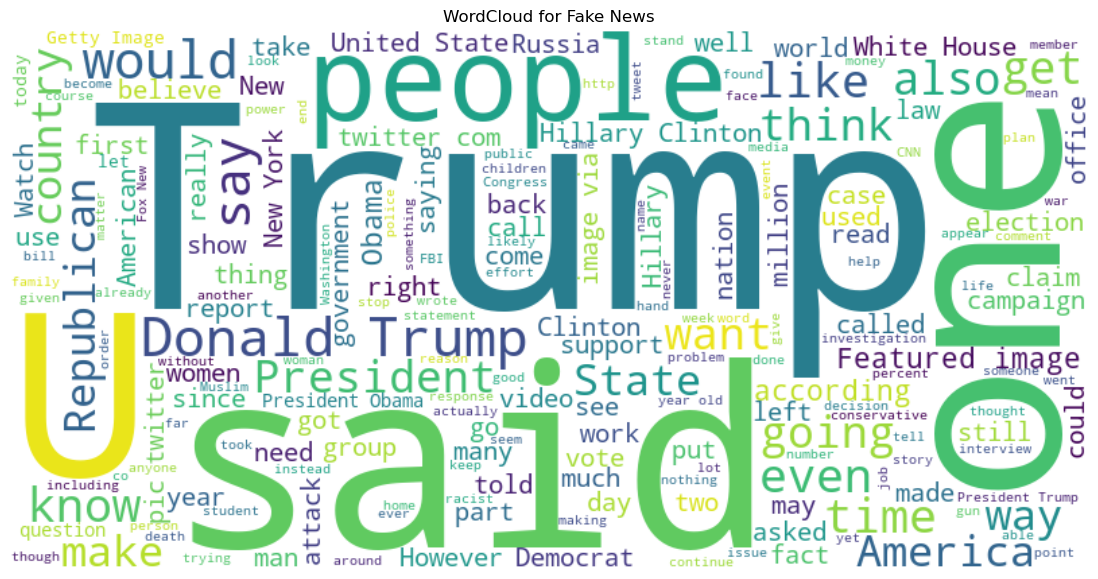

In [27]:
stop_words = set(stopwords.words("english"))

def show_wordcloud(data, label_type):
    text = " ".join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for {label_type} News")
    plt.show()

# WordCloud for True and Fake news
show_wordcloud(df[df['label'] == 'True']['text'], 'True')
show_wordcloud(df[df['label'] == 'Fake']['text'], 'Fake')

## Summary of EDA Insights

| Area                      | Key Insight |
|---------------------------|-------------|
| **Label Balance**             | The dataset is slightly skewed toward fake news but generally balanced. |
| **Subject Distribution**      | Fake news is more diffuse across subjects; true news is more focused (e.g., on "politicsNews"). |
| **Temporal Trends**           | Article counts spike in 2016–2017, reflecting real-world political events. |
| **Text Length**               | True news articles are generally longer and more detailed than fake ones. |
| **Capitalization & Punctuation** | Fake news uses more uppercase text and exclamation marks, suggesting a more sensational tone. |
| **Clickbait Usage**           | Clickbait phrases (e.g., "shocking", "you won't believe") appear more frequently in fake news. |
| **Sentiment Polarity**        | Fake news exhibits a broader range of sentiment polarity (more emotional); true news is more neutral. |
| **Duplicates**                | Fake news contains more duplicate articles, indicating content repetition or syndication. |
| **Semantic Clustering**       | Sentence embeddings show meaningful separation between fake and true articles, useful for modeling. |
